In [9]:
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json


torch.set_float32_matmul_precision('medium')


In [10]:
target_columns = [
    'Temperature', 'Humidity', 'Wind_Speed_kmh', 'Soil_Moisture', 
    'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos', 
    'Precipitation_accumulated'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [11]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [12]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []
all_metrics_horizon = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = BlockRNNModel(
        model="GRU",
        model_name=f"model_{fold+1}",
        input_chunk_length=72,
        output_chunk_length=24,
        hidden_dim=224,
        n_rnn_layers=3,
        n_epochs=100,
        batch_size=96,
        dropout=0.2,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.L1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.001210853477491263, "weight_decay": 3.398501349467249e-06},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"model_{fold+1}/", best=True)

    metrics_per_horizon = []
    for i in [1,4,8,12,16,20,24]:
        forecasts = model.historical_forecasts(
            val_scaled,
            forecast_horizon=i,
            stride=1,
            retrain=False,
            verbose=False,
            last_points_only=True,
        )

        forecasts_t = scaler.inverse_transform(forecasts)
        s = scaler.inverse_transform(val_scaled)
        metrics = {}
        print("Iniciando a verificação das séries temporais para constância...")
        try:
            for target in target_columns:
                metrics[target] = {
                    'MSE': mse(s[target], forecasts_t[target]),
                    'RMSE': rmse(s[target], forecasts_t[target]),
                    'MAE': mae(s[target], forecasts_t[target]),
                    'R2': r2_score(s[target], forecasts_t[target]),
                    'SMAPE': smape(s[target], forecasts_t[target]),
                    'WMAPE': wmape(s[target], forecasts_t[target]),
                }
            metrics_df = pd.DataFrame(metrics).T
            print("\nMétricas de performance:")
            print(metrics_df)
            metrics_per_horizon.append(metrics_df)
        except Exception as e:
            print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_metrics_horizon.append(metrics_per_horizon)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)


with open('all_metrics_horizon.json', 'w') as f:
    all_metrics_horizon_dict = [
        [df.to_dict() for df in fold_metrics] for fold_metrics in all_metrics_horizon
    ]
    json.dump(all_metrics_horizon_dict, f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 6.602
Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 6.573
Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 6.556
Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 6.541
Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 6.527
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 6.521
Monitored metric val_loss did not improve in the last 10 records. Best score: 6.521. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                   143.452911   11.977183    8.326218 -2.075030   
Humidity                     1905.012805   43.646452   31.987431 -5.239957   
Wind_Speed_kmh                  1.744492    1.320792    1.126897 -2.610017   
Soil_Moisture              697345.168460  835.071954  705.986081  0.434366   
Soil_Temperature               92.815819    9.634097    6.929675 -0.615519   
Wind_Dir_Sin                    1.060792    1.029947    0.874190 -1.929123   
Wind_Dir_Cos                    1.133683    1.064746    0.868307 -1.002298   
Precipitation_accumulated   59867.974192  244.679329  134.509623 -0.424922   

                                SMAPE       WMAPE  
Temperature                 41.282184   50.319380  
Humidity                    62.135789   42.060881  
Wind_Speed_kmh             173.223986  122.011564  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    68.338337    8.266700    5.867670 -0.462875   
Humidity                     1284.945235   35.846133   24.063698 -3.203656   
Wind_Speed_kmh                  2.364075    1.537555    1.386591 -3.888803   
Soil_Moisture              704721.123810  839.476696  715.916509  0.428744   
Soil_Temperature               37.905848    6.156773    4.634104  0.341228   
Wind_Dir_Sin                    1.312420    1.145609    1.003290 -2.631977   
Wind_Dir_Cos                    1.365261    1.168444    0.967897 -1.407645   
Precipitation_accumulated   60075.577532  245.103198  134.888525 -0.428017   

                                SMAPE       WMAPE  
Temperature                 34.008512   35.440142  
Humidity                    42.575534   31.652942  
Wind_Speed_kmh             156.621107  149.917494  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    45.784765    6.766444    5.714633  0.021651   
Humidity                     1705.751256   41.300742   28.432210 -4.573782   
Wind_Speed_kmh                  2.191300    1.480304    1.249563 -3.523555   
Soil_Moisture              606061.219126  778.499338  662.820681  0.509196   
Soil_Temperature               76.354812    8.738124    6.505684 -0.324275   
Wind_Dir_Sin                    0.944898    0.972059    0.822957 -1.619032   
Wind_Dir_Cos                    0.796132    0.892262    0.718257 -0.401685   
Precipitation_accumulated   60316.340210  245.593852  135.386786 -0.431272   

                                SMAPE       WMAPE  
Temperature                 41.949233   34.490063  
Humidity                    54.129965   37.419572  
Wind_Speed_kmh             164.470706  134.917858  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                1.022569e+02    10.112216    7.464699 -1.184454   
Humidity                   1.479179e+03    38.460094   27.606759 -3.822353   
Wind_Speed_kmh             2.856276e+00     1.690052    1.537048 -4.892420   
Soil_Moisture              1.064545e+06  1031.767879  861.433676  0.139213   
Soil_Temperature           5.822786e+01     7.630718    5.919120 -0.014227   
Wind_Dir_Sin               6.533673e-01     0.808311    0.625788 -0.807993   
Wind_Dir_Cos               8.110848e-01     0.900602    0.703718 -0.426946   
Precipitation_accumulated  6.045260e+04   245.871104  135.735673 -0.432038   

                                SMAPE       WMAPE  
Temperature                 40.403604   45.098726  
Humidity                    49.677190   36.327655  
Wind_Speed_kmh             166.636641  166.145525  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                   100.622084   10.031056    7.576145 -1.158502   
Humidity                      958.713867   30.963105   22.780459 -2.124062   
Wind_Speed_kmh                  1.218868    1.104024    0.931016 -1.523819   
Soil_Moisture              807920.104356  898.843760  755.648991  0.347373   
Soil_Temperature               63.238481    7.952263    6.169559 -0.108859   
Wind_Dir_Sin                    1.022258    1.011068    0.863993 -1.820816   
Wind_Dir_Cos                    0.874037    0.934900    0.779376 -0.537390   
Precipitation_accumulated   60496.813107  245.960999  135.960989 -0.430621   

                                SMAPE       WMAPE  
Temperature                 43.334921   45.860708  
Humidity                    36.381526   29.957327  
Wind_Speed_kmh             136.714834  100.976819  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                   121.097067   11.004411    8.031534 -1.595940   
Humidity                     1813.856206   42.589391   29.430237 -4.898299   
Wind_Speed_kmh                  2.951742    1.718063    1.438838 -5.095721   
Soil_Moisture              917524.831961  957.875165  811.122307  0.259416   
Soil_Temperature              217.487814   14.747468   10.769373 -2.805848   
Wind_Dir_Sin                    1.279964    1.131355    0.994413 -2.524889   
Wind_Dir_Cos                    0.780325    0.883360    0.732907 -0.371601   
Precipitation_accumulated   60865.852641  246.710058  136.607900 -0.436874   

                                SMAPE       WMAPE  
Temperature                 45.067663   48.665979  
Humidity                    56.740864   38.691610  
Wind_Speed_kmh             187.126180  156.048437  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                   202.118386   14.216835   10.072140 -3.320144   
Humidity                     2623.365047   51.218796   36.228798 -7.505947   
Wind_Speed_kmh                  1.903089    1.379525    1.158745 -2.918883   
Soil_Moisture              604719.265098  777.636975  660.605439  0.512287   
Soil_Temperature              112.528237   10.607933    7.777395 -0.963600   
Wind_Dir_Sin                    1.386746    1.177602    1.040631 -2.819003   
Wind_Dir_Cos                    0.793441    0.890753    0.734434 -0.392333   
Precipitation_accumulated   60820.122687  246.617361  136.748296 -0.433327   

                                SMAPE       WMAPE  
Temperature                 46.964140   61.018220  
Humidity                    71.878582   47.636997  
Wind_Speed_kmh             169.695004  125.720886  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.238
Metric val_loss improved by 0.131 >= min_delta = 0.001. New best score: 0.107
Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.095
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.090
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.090. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argu

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    21.867862    4.676309    4.096425   
Humidity                       82.905545    9.105248    7.969460   
Wind_Speed_kmh                  0.176274    0.419851    0.333135   
Soil_Moisture              667423.449916  816.959883  736.287156   
Soil_Temperature               29.387765    5.421048    4.830052   
Wind_Dir_Sin                    0.409469    0.639898    0.534989   
Wind_Dir_Cos                    0.867330    0.931305    0.750016   
Precipitation_accumulated     104.926157   10.243347    7.759122   

                                     R2       SMAPE         WMAPE  
Temperature               -1.772646e+00   27.877810  2.642425e+01  
Humidity                  -2.982988e+00    9.278753  9.270471e+00  
Wind_Speed_kmh            -1.961209e+07  199.993393  1.048977e+07  
Soil_Moisture            

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    36.541933    6.044992    5.261250   
Humidity                      124.524975   11.159076    9.651140   
Wind_Speed_kmh                  0.436475    0.660663    0.570725   
Soil_Moisture              631571.521515  794.714742  704.055012   
Soil_Temperature               39.412591    6.277945    5.633480   
Wind_Dir_Sin                    0.377338    0.614278    0.523380   
Wind_Dir_Cos                    0.864041    0.929538    0.719303   
Precipitation_accumulated     162.240338   12.737360   10.034463   

                                     R2       SMAPE         WMAPE  
Temperature               -3.652796e+00   35.307352  3.396175e+01  
Humidity                  -4.974119e+00   11.454540  1.122583e+01  
Wind_Speed_kmh            -4.845077e+07  199.967092  1.792990e+07  
Soil_Moisture            

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    34.940155    5.911020    5.231713   
Humidity                      126.749923   11.258327    9.516918   
Wind_Speed_kmh                  0.177631    0.421463    0.349062   
Soil_Moisture              622482.257242  788.975448  693.116199   
Soil_Temperature               36.091766    6.007642    5.319139   
Wind_Dir_Sin                    0.439419    0.662887    0.567781   
Wind_Dir_Cos                    0.984760    0.992351    0.777290   
Precipitation_accumulated     327.676292   18.101831   16.571285   

                                     R2       SMAPE         WMAPE  
Temperature               -3.471478e+00   36.924811  3.380156e+01  
Humidity                  -5.068559e+00   11.520162  1.106867e+01  
Wind_Speed_kmh            -1.965772e+07  199.991083  1.093264e+07  
Soil_Moisture            

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    24.130491    4.912280    4.324727   
Humidity                      115.902666   10.765810    9.226460   
Wind_Speed_kmh                  0.809495    0.899719    0.787156   
Soil_Moisture              569664.500093  754.761221  645.579517   
Soil_Temperature               27.910137    5.283005    4.557819   
Wind_Dir_Sin                    0.356529    0.597101    0.498425   
Wind_Dir_Cos                    0.829808    0.910938    0.706091   
Precipitation_accumulated      63.903794    7.993985    6.458130   

                                     R2       SMAPE         WMAPE  
Temperature               -2.102087e+00   30.638691  2.796596e+01  
Humidity                  -4.539886e+00   10.561294  1.072967e+01  
Wind_Speed_kmh            -8.930920e+07  199.962560  2.457815e+07  
Soil_Moisture             -1.053527e+02    9.501949  1.011518e+01  
Soil_Temperature     

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    33.106330    5.753810    4.941675   
Humidity                       96.050199    9.800520    8.390075   
Wind_Speed_kmh                  0.396575    0.629742    0.598503   
Soil_Moisture              738867.919224  859.574266  758.023311   
Soil_Temperature               28.110616    5.301945    4.687840   
Wind_Dir_Sin                    0.323268    0.568567    0.455405   
Wind_Dir_Cos                    0.955784    0.977642    0.760509   
Precipitation_accumulated      59.949383    7.742699    6.114794   

                                     R2       SMAPE         WMAPE  
Temperature               -3.272363e+00   40.608391  3.198208e+01  
Humidity                  -3.582960e+00    9.768951  9.755970e+00  
Wind_Speed_kmh            -4.361857e+07  199.995618  1.863019e+07  
Soil_Moisture            

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    28.412978    5.330383    4.582725   
Humidity                       67.611674    8.222632    7.075359   
Wind_Speed_kmh                  0.607139    0.779192    0.732198   
Soil_Moisture              678654.447611  823.804860  746.429663   
Soil_Temperature               22.341084    4.726636    4.090989   
Wind_Dir_Sin                    0.346505    0.588647    0.478121   
Wind_Dir_Cos                    0.785145    0.886084    0.679546   
Precipitation_accumulated      47.452604    6.888585    5.167378   

                                     R2       SMAPE         WMAPE  
Temperature               -2.688801e+00   33.670200  2.968715e+01  
Humidity                  -2.222366e+00    8.100375  8.226149e+00  
Wind_Speed_kmh            -1.131320e+09  199.998206  1.136079e+08  
Soil_Moisture            

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    22.733459    4.767962    4.090697   
Humidity                       59.637836    7.722554    6.559101   
Wind_Speed_kmh                  0.174207    0.417381    0.353469   
Soil_Moisture              569159.131651  754.426359  659.530803   
Soil_Temperature               33.940215    5.825823    5.179879   
Wind_Dir_Sin                    0.325365    0.570408    0.451965   
Wind_Dir_Cos                    0.658435    0.811440    0.623431   
Precipitation_accumulated      38.472548    6.202624    5.078278   

                                     R2       SMAPE      WMAPE  
Temperature               -1.988863e+00   28.340831  26.532907  
Humidity                  -1.848468e+00    7.564281   7.624332  
Wind_Speed_kmh                     -inf  200.000000        inf  
Soil_Moisture             -1.094092e+

Metric val_loss improved. New best score: 0.079
Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.040
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.033
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.027
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.024
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.024. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    0.985316    0.992631    0.820381   -0.775302   
Humidity                      19.782108    4.447708    3.754846   -1.062143   
Wind_Speed_kmh                 0.040650    0.201618    0.188916        -inf   
Soil_Moisture              65913.901868  256.737029  227.359824   -0.982552   
Soil_Temperature               1.614106    1.270475    1.110563   -7.413409   
Wind_Dir_Sin                   0.001768    0.042049    0.040248        -inf   
Wind_Dir_Cos                   0.000612    0.024741    0.021233        -inf   
Precipitation_accumulated     11.994911    3.463367    3.001727 -297.853384   

                                SMAPE      WMAPE  
Temperature                  9.308093   8.849403  
Humidity                     4.095859   4.123610  
Wind_Speed_kmh             200.000000        

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE         R2  \
Temperature                    2.927005    1.710849    1.463383  -4.301793   
Humidity                      16.319487    4.039738    3.292208  -0.699703   
Wind_Speed_kmh                 0.015821    0.125781    0.111107       -inf   
Soil_Moisture              90528.528682  300.879592  271.235539  -1.758813   
Soil_Temperature               3.304026    1.817698    1.640927 -16.392986   
Wind_Dir_Sin                   0.000108    0.010374    0.008099       -inf   
Wind_Dir_Cos                   0.001472    0.038365    0.035046       -inf   
Precipitation_accumulated      3.904845    1.976068    1.636945 -96.371781   

                                SMAPE      WMAPE  
Temperature                 17.537734  15.790700  
Humidity                     3.616197   3.615757  
Wind_Speed_kmh             200.000000        inf  
Soi

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     1.348502    1.161250    0.929055    -1.485363   
Humidity                       18.118503    4.256583    3.651297    -0.883574   
Wind_Speed_kmh                  0.010573    0.102824    0.083554         -inf   
Soil_Moisture              118386.013051  344.072686  311.573964    -2.676814   
Soil_Temperature                4.565803    2.136774    1.922259   -23.628811   
Wind_Dir_Sin                    0.000544    0.023316    0.019930         -inf   
Wind_Dir_Cos                    0.000298    0.017264    0.013558         -inf   
Precipitation_accumulated     101.751864   10.087213    9.404889 -2539.244051   

                                SMAPE      WMAPE  
Temperature                 10.620149  10.031296  
Humidity                     4.035795   4.010397  
Wind_Speed_kmh             

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE         R2  \
Temperature                    1.425595    1.193983    0.988376  -1.645107   
Humidity                      16.614331    4.076068    3.444998  -0.723655   
Wind_Speed_kmh                 0.012344    0.111104    0.097520       -inf   
Soil_Moisture              88458.863834  297.420349  263.763587  -1.771622   
Soil_Temperature               1.670564    1.292503    1.114306  -8.103846   
Wind_Dir_Sin                   0.001312    0.036215    0.032000       -inf   
Wind_Dir_Cos                   0.000087    0.009301    0.007807       -inf   
Precipitation_accumulated      2.987905    1.728556    1.452781 -73.682457   

                                SMAPE      WMAPE  
Temperature                 11.355676  10.676428  
Humidity                     3.808539   3.784036  
Wind_Speed_kmh             200.000000        inf  
Soi

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    0.777331    0.881664    0.735203    -0.455011   
Humidity                      16.729559    4.090178    3.412275    -0.732584   
Wind_Speed_kmh                 0.006492    0.080572    0.065849         -inf   
Soil_Moisture              81521.839851  285.520297  253.022479    -1.559202   
Soil_Temperature               0.332298    0.576453    0.447985    -0.835809   
Wind_Dir_Sin                   0.000231    0.015197    0.011865         -inf   
Wind_Dir_Cos                   0.000831    0.028827    0.025586         -inf   
Precipitation_accumulated     49.602161    7.042880    6.758182 -1240.328128   

                                SMAPE     WMAPE  
Temperature                  8.186022  7.945458  
Humidity                     3.768860  3.748351  
Wind_Speed_kmh             200.000000  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     2.104879    1.450820    1.247173    -2.977887   
Humidity                       18.155476    4.260924    3.549686    -0.876845   
Wind_Speed_kmh                  0.001435    0.037876    0.031326         -inf   
Soil_Moisture              133306.143724  365.111139  328.803942    -3.193076   
Soil_Temperature                2.169252    1.472838    1.302862   -11.172164   
Wind_Dir_Sin                    0.001697    0.041190    0.036740         -inf   
Wind_Dir_Cos                    0.000416    0.020398    0.016226         -inf   
Precipitation_accumulated      55.018767    7.417464    6.948239 -1377.626433   

                                SMAPE      WMAPE  
Temperature                 14.648314  13.485043  
Humidity                     3.895037   3.899561  
Wind_Speed_kmh             

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2328: RuntimeWarning: divide by zero encountered in divide
/hom

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE         R2  \
Temperature                    4.171923    2.042529    1.817791  -6.962334   
Humidity                      19.716826    4.440363    3.616281  -1.034213   
Wind_Speed_kmh                 0.026885    0.163967    0.149992       -inf   
Soil_Moisture              91707.139706  302.831867  266.040692  -1.890446   
Soil_Temperature               2.745869    1.657066    1.470599 -14.658753   
Wind_Dir_Sin                   0.003014    0.054898    0.048208       -inf   
Wind_Dir_Cos                   0.000360    0.018963    0.015357       -inf   
Precipitation_accumulated      3.758739    1.938747    1.506637 -93.306922   

                                SMAPE      WMAPE  
Temperature                 22.509513  19.664615  
Humidity                     3.959405   3.972971  
Wind_Speed_kmh             200.000000        inf  
Soi

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.121
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.120
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.115
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.114
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.110
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.109
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.105
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.103
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.103. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                6.081459e+00     2.466061    1.735596  -0.149045   
Humidity                   6.084078e+01     7.800050    7.126216   0.282949   
Wind_Speed_kmh             9.272341e-01     0.962930    0.449672  -0.014364   
Soil_Moisture              1.003397e+06  1001.696904  654.693538   0.274270   
Soil_Temperature           4.208494e+00     2.051461    1.737469   0.287255   
Wind_Dir_Sin               2.829765e-01     0.531955    0.360105  -0.033382   
Wind_Dir_Cos               6.136163e-01     0.783337    0.471057  -0.300868   
Precipitation_accumulated  4.584694e+01     6.771037    4.366838 -38.292613   

                                SMAPE      WMAPE  
Temperature                 39.020744  30.906057  
Humidity                     8.317800   8.460357  
Wind_Speed_kmh             155.070953  90.708

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                6.473614e+00     2.544330    1.876183 -0.221465   
Humidity                   7.954919e+01     8.919035    8.280851  0.064513   
Wind_Speed_kmh             8.882439e-01     0.942467    0.450349  0.029984   
Soil_Moisture              1.074001e+06  1036.340370  684.390895  0.224126   
Soil_Temperature           5.843460e+00     2.417325    1.989199  0.008948   
Wind_Dir_Sin               2.821433e-01     0.531172    0.360362 -0.028194   
Wind_Dir_Cos               5.996463e-01     0.774368    0.467014 -0.270016   
Precipitation_accumulated  5.713240e+00     2.390239    1.747254 -3.904914   

                                SMAPE      WMAPE  
Temperature                 40.211859  33.429119  
Humidity                     9.657537   9.830660  
Wind_Speed_kmh             157.582493  90.637262  
Soi

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                6.651678e+00     2.579085    1.904215  -0.252140   
Humidity                   7.427683e+01     8.618401    7.980884   0.128950   
Wind_Speed_kmh             9.983450e-01     0.999172    0.479853  -0.087715   
Soil_Moisture              1.170503e+06  1081.897908  704.130573   0.155745   
Soil_Temperature           3.621781e+00     1.903098    1.444027   0.384822   
Wind_Dir_Sin               2.936879e-01     0.541930    0.371000  -0.067287   
Wind_Dir_Cos               6.614613e-01     0.813303    0.489839  -0.399126   
Precipitation_accumulated  2.081568e+01     4.562421    3.374748 -16.912544   

                                SMAPE      WMAPE  
Temperature                 40.834515  33.948992  
Humidity                     9.335816   9.473612  
Wind_Speed_kmh             160.770757  96.280

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                7.157681e+00     2.675384    1.983737 -0.344887   
Humidity                   8.420833e+01     9.176510    8.542265  0.015125   
Wind_Speed_kmh             1.129245e+00     1.062659    0.507619 -0.227463   
Soil_Moisture              1.002547e+06  1001.272913  651.603169  0.278022   
Soil_Temperature           4.713671e+00     2.171099    1.639524  0.198323   
Wind_Dir_Sin               2.982517e-01     0.546124    0.374789 -0.080848   
Wind_Dir_Cos               6.795542e-01     0.824351    0.501862 -0.435545   
Precipitation_accumulated  3.275962e+00     1.809962    1.386998 -1.825832   

                                SMAPE       WMAPE  
Temperature                 44.312378   35.392020  
Humidity                     9.966152   10.138847  
Wind_Speed_kmh             168.979343  101.539086  

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                6.891094e+00     2.625089    1.919686  -0.298959   
Humidity                   1.149631e+02    10.722083   10.118792  -0.341542   
Wind_Speed_kmh             9.688553e-01     0.984304    0.454288  -0.050663   
Soil_Moisture              1.031105e+06  1015.433594  651.683649   0.258627   
Soil_Temperature           4.400145e+00     2.097652    1.521301   0.250289   
Wind_Dir_Sin               3.031975e-01     0.550634    0.377157  -0.095697   
Wind_Dir_Cos               6.614759e-01     0.813312    0.491512  -0.395563   
Precipitation_accumulated  2.261008e+01     4.755006    3.468848 -18.551241   

                                SMAPE       WMAPE  
Temperature                 41.886231   34.307977  
Humidity                    11.755508   12.008034  
Wind_Speed_kmh             155.117264   90

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                5.654484e+00     2.377916    1.898809   -0.064204   
Humidity                   1.098038e+02    10.478730    9.856350   -0.277859   
Wind_Speed_kmh             8.365346e-01     0.914623    0.455675    0.094954   
Soil_Moisture              1.176318e+06  1084.581819  703.133565    0.155541   
Soil_Temperature           6.747348e+00     2.597566    2.115249   -0.151446   
Wind_Dir_Sin               2.848329e-01     0.533697    0.363796   -0.026443   
Wind_Dir_Cos               6.488325e-01     0.805501    0.489927   -0.367139   
Precipitation_accumulated  1.358884e+02    11.657117    8.170255 -116.799463   

                                SMAPE      WMAPE  
Temperature                 38.326774  33.964697  
Humidity                    11.458873  11.695216  
Wind_Speed_kmh             153.36151

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                6.047226e+00     2.459111    2.074770 -0.135748   
Humidity                   1.176358e+02    10.846004   10.294575 -0.365201   
Wind_Speed_kmh             1.155265e+00     1.074832    0.537927 -0.246949   
Soil_Moisture              1.284824e+06  1133.500620  740.473893  0.079087   
Soil_Temperature           9.668001e+00     3.109341    2.694082 -0.652377   
Wind_Dir_Sin               2.953848e-01     0.543493    0.370466 -0.061474   
Wind_Dir_Cos               7.113913e-01     0.843440    0.514549 -0.497047   
Precipitation_accumulated  9.212257e+00     3.035170    2.717780 -7.006462   

                                SMAPE       WMAPE  
Temperature                 40.341273   37.138964  
Humidity                    11.951166   12.213872  
Wind_Speed_kmh             176.617449  106.609060  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.211
Metric val_loss improved by 0.073 >= min_delta = 0.001. New best score: 0.138
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.134
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.130
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.128
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.128. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers whic

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                   13.145489    3.625671    2.833706    0.529465   
Humidity                      53.523490    7.315975    6.020521    0.655842   
Wind_Speed_kmh                 1.144640    1.069878    0.815208    0.099252   
Soil_Moisture              83375.405940  288.747997  256.902541  -12.487932   
Soil_Temperature               2.953691    1.718631    1.426697    0.773239   
Wind_Dir_Sin                   0.565434    0.751954    0.658136   -0.026555   
Wind_Dir_Cos                   0.370843    0.608969    0.512632   -0.052190   
Precipitation_accumulated    304.448974   17.448466   16.538618 -201.506933   

                                SMAPE      WMAPE  
Temperature                 33.546560  28.156238  
Humidity                     7.181141   6.995184  
Wind_Speed_kmh              69.649595  54.893

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE         R2  \
Temperature                    27.624737    5.255924    4.523889   0.011080   
Humidity                       69.049521    8.309604    6.755835   0.556098   
Wind_Speed_kmh                  1.139158    1.067314    0.835317   0.105243   
Soil_Moisture              103282.396191  321.375787  286.320545 -15.718039   
Soil_Temperature                5.752431    2.398423    2.112363   0.557650   
Wind_Dir_Sin                    0.611026    0.781681    0.685717  -0.107555   
Wind_Dir_Cos                    0.387661    0.622625    0.525760  -0.100799   
Precipitation_accumulated     131.262374   11.456979   10.827946 -87.272297   

                                SMAPE      WMAPE  
Temperature                 66.192279  44.896057  
Humidity                     8.044060   7.847129  
Wind_Speed_kmh              70.043514  56.283

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE         R2  \
Temperature                   24.839425    4.983917    4.267937   0.107381   
Humidity                      76.033333    8.719709    7.043943   0.512502   
Wind_Speed_kmh                 1.108809    1.053000    0.832400   0.130997   
Soil_Moisture              87060.321986  295.059862  260.223679 -13.089042   
Soil_Temperature              19.733932    4.442289    4.099309  -0.526633   
Wind_Dir_Sin                   0.602354    0.776115    0.697467  -0.091015   
Wind_Dir_Cos                   0.388046    0.622933    0.526664  -0.103137   
Precipitation_accumulated     98.893778    9.944535    9.044359 -66.508323   

                                SMAPE      WMAPE  
Temperature                 64.383532  42.254666  
Humidity                     8.411362   8.180595  
Wind_Speed_kmh              69.510857  56.149816  
Soi

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                   15.789659    3.973620    3.237082    0.428009   
Humidity                      83.148706    9.118591    7.391609    0.468462   
Wind_Speed_kmh                 1.246700    1.116557    0.845465    0.019197   
Soil_Moisture              88835.086530  298.052154  271.502045  -13.387557   
Soil_Temperature               8.670097    2.944503    2.518625    0.322318   
Wind_Dir_Sin                   0.628477    0.792765    0.707164   -0.136576   
Wind_Dir_Cos                   0.389990    0.624491    0.521026   -0.113935   
Precipitation_accumulated    260.388829   16.136568   15.250369 -179.511215   

                                SMAPE      WMAPE  
Temperature                 41.778575  31.953753  
Humidity                     8.835538   8.584905  
Wind_Speed_kmh              72.826381  57.224

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                    19.388778    4.403269    3.660226    0.290490   
Humidity                       84.047224    9.167727    7.396133    0.463461   
Wind_Speed_kmh                  1.124469    1.060410    0.813004    0.115139   
Soil_Moisture              163880.817264  404.821957  379.104489  -25.595620   
Soil_Temperature                8.994472    2.999078    2.645948    0.288045   
Wind_Dir_Sin                    0.613183    0.783060    0.696456   -0.108021   
Wind_Dir_Cos                    0.415095    0.644279    0.529633   -0.185625   
Precipitation_accumulated     265.646362   16.298661   15.184188 -186.101457   

                                SMAPE      WMAPE  
Temperature                 47.762378  36.030389  
Humidity                     8.816430   8.592979  
Wind_Speed_kmh              69.68276

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                    22.609922    4.754989    3.958291    0.170847   
Humidity                       88.126821    9.387589    7.499314    0.438873   
Wind_Speed_kmh                  1.119589    1.058106    0.816203    0.121072   
Soil_Moisture              103296.263598  321.397361  298.504809  -15.819112   
Soil_Temperature                9.663296    3.108584    2.790188    0.228720   
Wind_Dir_Sin                    0.617400    0.785748    0.683569   -0.114317   
Wind_Dir_Cos                    0.402288    0.634262    0.518957   -0.148249   
Precipitation_accumulated     594.302595   24.378322   22.702403 -424.480427   

                                SMAPE      WMAPE  
Temperature                 50.826781  38.886020  
Humidity                     9.018271   8.713865  
Wind_Speed_kmh              69.43538

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE         R2  \
Temperature                    21.955348    4.685653    3.783090   0.195289   
Humidity                      111.267167   10.548325    8.484271   0.293631   
Wind_Speed_kmh                  1.123401    1.059906    0.834494   0.120177   
Soil_Moisture              102894.202642  320.771262  279.828363 -15.813887   
Soil_Temperature                8.655503    2.942024    2.523496   0.306996   
Wind_Dir_Sin                    0.617948    0.786097    0.682324  -0.115332   
Wind_Dir_Cos                    0.417438    0.646095    0.524919  -0.188712   
Precipitation_accumulated     125.751291   11.213888    9.407601 -90.558813   

                                SMAPE      WMAPE  
Temperature                 45.295465  37.111957  
Humidity                    10.186375   9.858216  
Wind_Speed_kmh              70.280008  56.281

In [13]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"model_{best_fold}/", best=True)

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=224, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, model_name=model_3, input_chunk_length=72, output_chunk_length=24, n_epochs=100, batch_size=96, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x71730115cf20>]}, loss_fn=L1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.001210853477491263, 'weight_decay': 3.398501349467249e-06})

In [14]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Humidity', 'Wind_Speed_kmh',
       'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos',
       'Precipitation_accumulated', 'fold'],
      dtype='object', name='component')


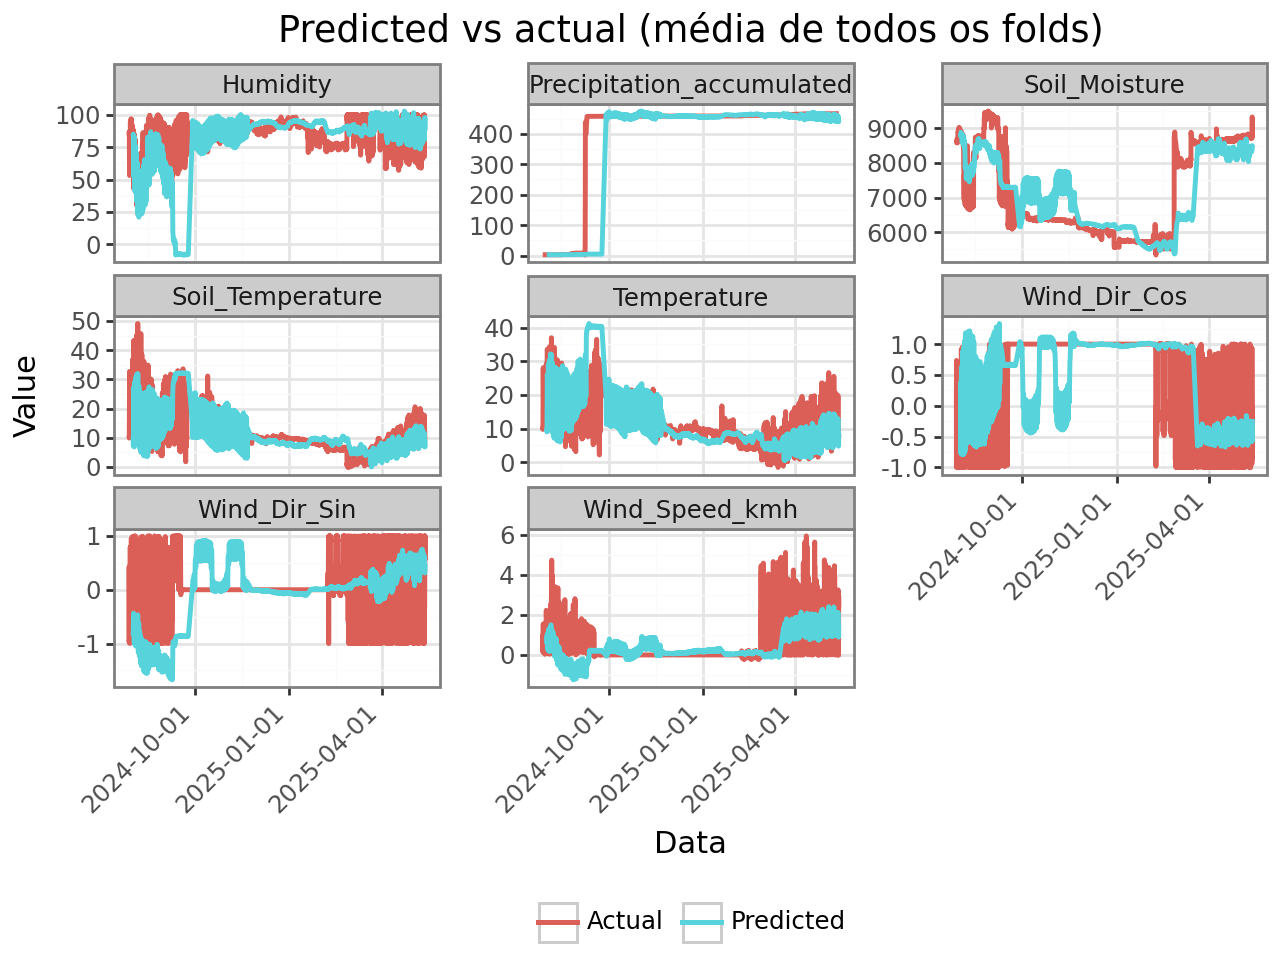

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


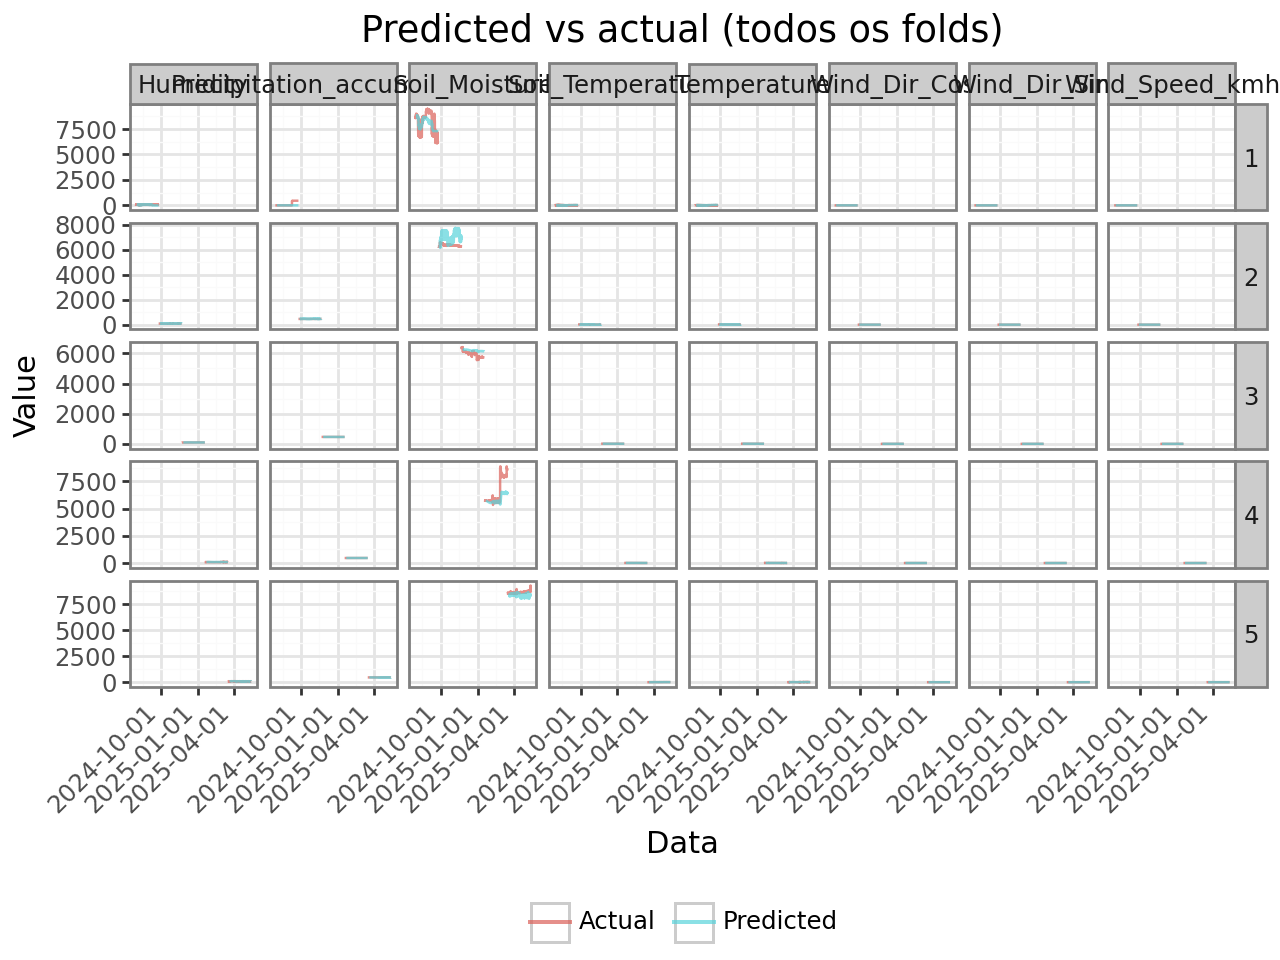

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_4792/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


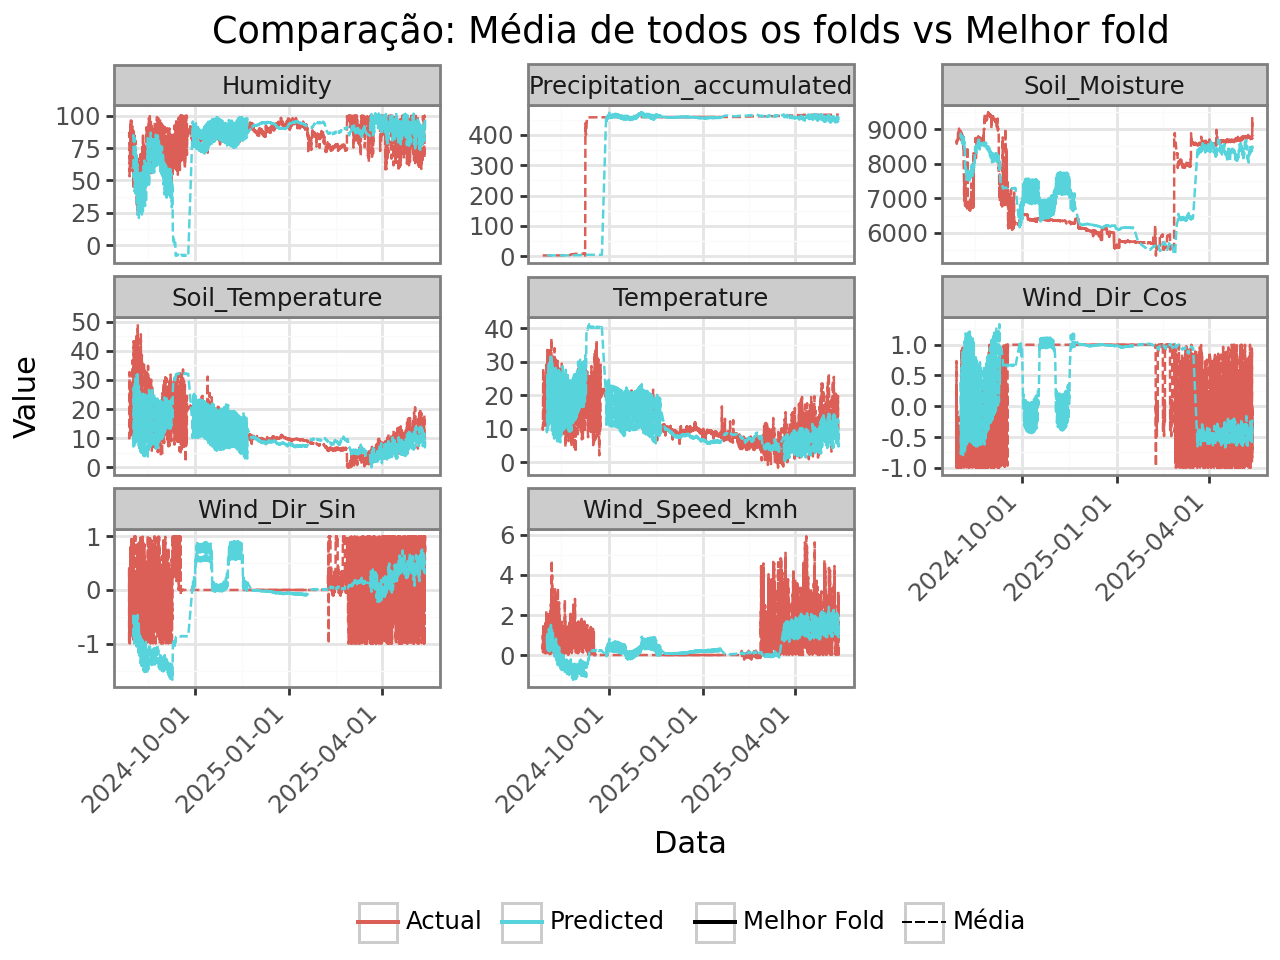

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [15]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [16]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
